In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Recommendation systems: Deep Model

This model is made up of feature layers that have users, movies and movie genres embedings followed by a neural network with dense layers and finally one output that is the rating prediction that input user(id) could assign to input movie(id).

**Inputs**
* **User id**: Really this is traducet as a sequence because embedding layers only can manage sequenced identifiers.
* **Movie id**: Idem to User id.
* **Movie genres**: One column by genre.

**Output**
*  **Rating prediction** that user could assign to movie.

**Links**
* [Deep Learning With Keras: Recommender Systems](https://www.johnwittenauer.net/deep-learning-with-keras-recommender-systems/)
* [Collaborative Filtering for Movie Recommendations](https://keras.io/examples/structured_data/collaborative_filtering_movielens/)
* [Movie lens datasets](https://grouplens.org/datasets/movielens/)
* [Recommendation Systems Benchmarks](https://paperswithcode.com/task/recommendation-systems)

## Required libraries

In [2]:
import sys
sys.path.append('../src')

import numpy as np
import pandas as pd
import tensorflow as tf

from util import tf_detected_devices, tf_version, plot_model, Config, LoggerFactory, create_path
from callback import MetricsPlotter
from data import DataFrameDataGenerator
from recommendation import UserMovieGenderEmbeddingDenseModelFactory, RecommendationsDataGenerator
from spark import SparkSessionFactory, read_csv, column_values, train_test_split, PageSet, get_columns, get_rows

import pyspark.sql.types as t
import pyspark.sql as s
import pyspark.sql.functions as f

## Logger config

In [3]:
config = Config(path='../config/config.yaml')
LoggerFactory(config['logger']).create()

<RootLogger root (INFO)>

## Config parameters

Setup test_mode variable to enable or disable model train before check their prediction precision:

In [4]:
train_model = True

## Check environment

**Step 1**: Make sure that nvidia driver is installed runing next command:

In [5]:
!nvidia-smi --query-gpu=gpu_name,memory.total --format=csv | sed -n 2p

GeForce RTX 3080, 10015 MiB


**Note:** If this shows a GPU model and memory size, that's all right, otherwise make suze that has the nvidia driver installed.

**Step 2**: Let's check tensorflow version:

In [6]:
tf_version()

'Tensorflow version: 2.5.0-dev20210114'

**Step 3**: Let's check devices that tensorflow detect:

In [7]:
tf_detected_devices()

,Name,Device Type,Memory,Description
0,/device:CPU:0,CPU,256M,
1,/device:GPU:0,GPU,7G,"device: 0, name: GeForce RTX 3080, pci bus id:..."


In [8]:
tf.debugging.set_log_device_placement(False)

**Step 4**: Make sure that tensorflow detect cuda libs and GPU devices.

In [9]:
tf.test.is_built_with_cuda()

True

In [10]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Prepare model input data

**Step 1**: Create a predefined spark session. this is used to create a pipeline that build the model input features. 

In [11]:
session = SparkSessionFactory.create()
session

In [12]:
session.sparkContext.getConf().getAll()

[('spark.driver.host', 'skynet.local'),
 ('spark.executor.instances', '12'),
 ('spark.executor.id', 'driver'),
 ('spark.executor.memory', '1G'),
 ('spark.driver.port', '36887'),
 ('spark.app.name', 'recommendations'),
 ('spark.app.id', 'local-1611024217053'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.memory', '4G'),
 ('spark.ui.showConsoleProgress', 'true')]

**Note**: When create a spark session this run a new spark cluster with one instance in localhost. You can monitor instance jobs clicking the **Spark UI** link. 

**Step 2**: Load raw dataset to a spark dataset. 

In [13]:
TEMP_PATH = './temp'
TRAIN_PATH = f'{TEMP_PATH}/train'
VAL_PATH = f'{TEMP_PATH}/val'
TEST_PATH = f'{TEMP_PATH}/test'

In [14]:
train_set = read_csv(session, f'{TRAIN_PATH}/*.csv')

In [15]:
val_set = read_csv(session, f'{VAL_PATH}/*.csv')

In [16]:
test_set = read_csv(session, f'{TEST_PATH}/*.csv')

In [17]:
print(f'Train set size: {"{:,}".format(train_set.count())} samples.')
print(f'Validation set size: {"{:,}".format(val_set.count())} samples.')

Train set size: 90,656 samples.
Validation set size: 6,888 samples.


**Step 3:** Let's see min and max value of rating column.

In [18]:
min_max = train_set.agg(f.min('rating'), f.max('rating')).collect()[0]
min_rating, max_rating = min_max[0], min_max[1]

print('Ratting - min: ', min_rating, 'max:', max_rating)

Ratting - min:  0.5 max: 5.0


**Step 4:** Let's see all dataset columns.

In [19]:
class ColumnService:
    def __init__(self, columns):
        excluded_columns = ['user_id', 'movie_id']
        self.labels = ['rating']

        features = list(set(columns) - set(self.labels) - set(excluded_columns))
        features = sorted(features, key=lambda x: 'gen_' in x)

        self.gender_features = [c for c in features if 'gen_' in c]
        self.emb_features = [c for c in features if '_seq' in c]
        self.emb_features = sorted(self.emb_features, key=lambda x: 'user' in x, reverse=True)
   
        self.features = self.emb_features + self.gender_features

column_manager = ColumnService(train_set.columns)

**Step 5**: Calculate train, val batch_size and plot interval.

In [20]:
import math

steps             = 100
epochs            = 20
plot_interval     = math.floor(steps / 10)

train_batch_size  = math.floor(train_set.count() / steps)
val_batch_size    = math.floor(val_set.count() / steps)
evaluate_interval = plot_interval + 1

In [21]:
print(f'Train Batch Size      : {"{:,}".format(train_batch_size)}.')
print(f'Validation Batch Size : {"{:,}".format(val_batch_size)}.')
print('Plot Interval         :', plot_interval)
print('Evaluate Interval     :', evaluate_interval)
print('Epochs                :', epochs)

Train Batch Size      : 906.
Validation Batch Size : 68.
Plot Interval         : 10
Evaluate Interval     : 11
Epochs                : 20


In [22]:
train_generator = RecommendationsDataGenerator(
    train_set,
    train_batch_size,
    column_manager,
    shuffle=True,
    name='train'
)

INFO 2021-01-18 23:43:43 - page-set-140659394991728 - Page Size: 906
INFO 2021-01-18 23:43:43 - page-set-140659394991728 - Pages Count: 101
INFO 2021-01-18 23:43:43 - page-set-140659394991728 - Total elements: 90656


In [23]:
val_generator = RecommendationsDataGenerator(
    val_set,
    val_batch_size,
    column_manager,
    shuffle=False,
    name='val'
)

INFO 2021-01-18 23:43:44 - page-set-140659394981264 - Page Size: 68
INFO 2021-01-18 23:43:44 - page-set-140659394981264 - Pages Count: 102
INFO 2021-01-18 23:43:44 - page-set-140659394981264 - Total elements: 6888


In [24]:
n_users = train_set.select('user_seq') \
            .union(val_set.select('user_seq')) \
            .union(test_set.select('user_seq')) \
            .distinct() \
            .count()

n_movies = train_set.select('movie_seq') \
            .union(val_set.select('movie_seq')) \
            .union(test_set.select('movie_seq')) \
            .distinct() \
            .count()

print(f'Train set size: {"{:,}".format(n_users)}.')
print(f'Validation set size: {"{:,}".format(n_movies)}.')

Train set size: 251.
Validation set size: 449.


In [26]:
model = UserMovieGenderEmbeddingDenseModelFactory.create(
    n_users, 
    n_movies,
    n_genders=len(column_manager.gender_features),
    min_rating=min_rating, 
    max_rating=max_rating,
    user_n_min_factors=50,
    movie_n_min_factors=50,
    lr=0.001,
    units=[512, 512, 512, 512],
    dropout=[0.5, 0.5, 0.5, 0.5]
)

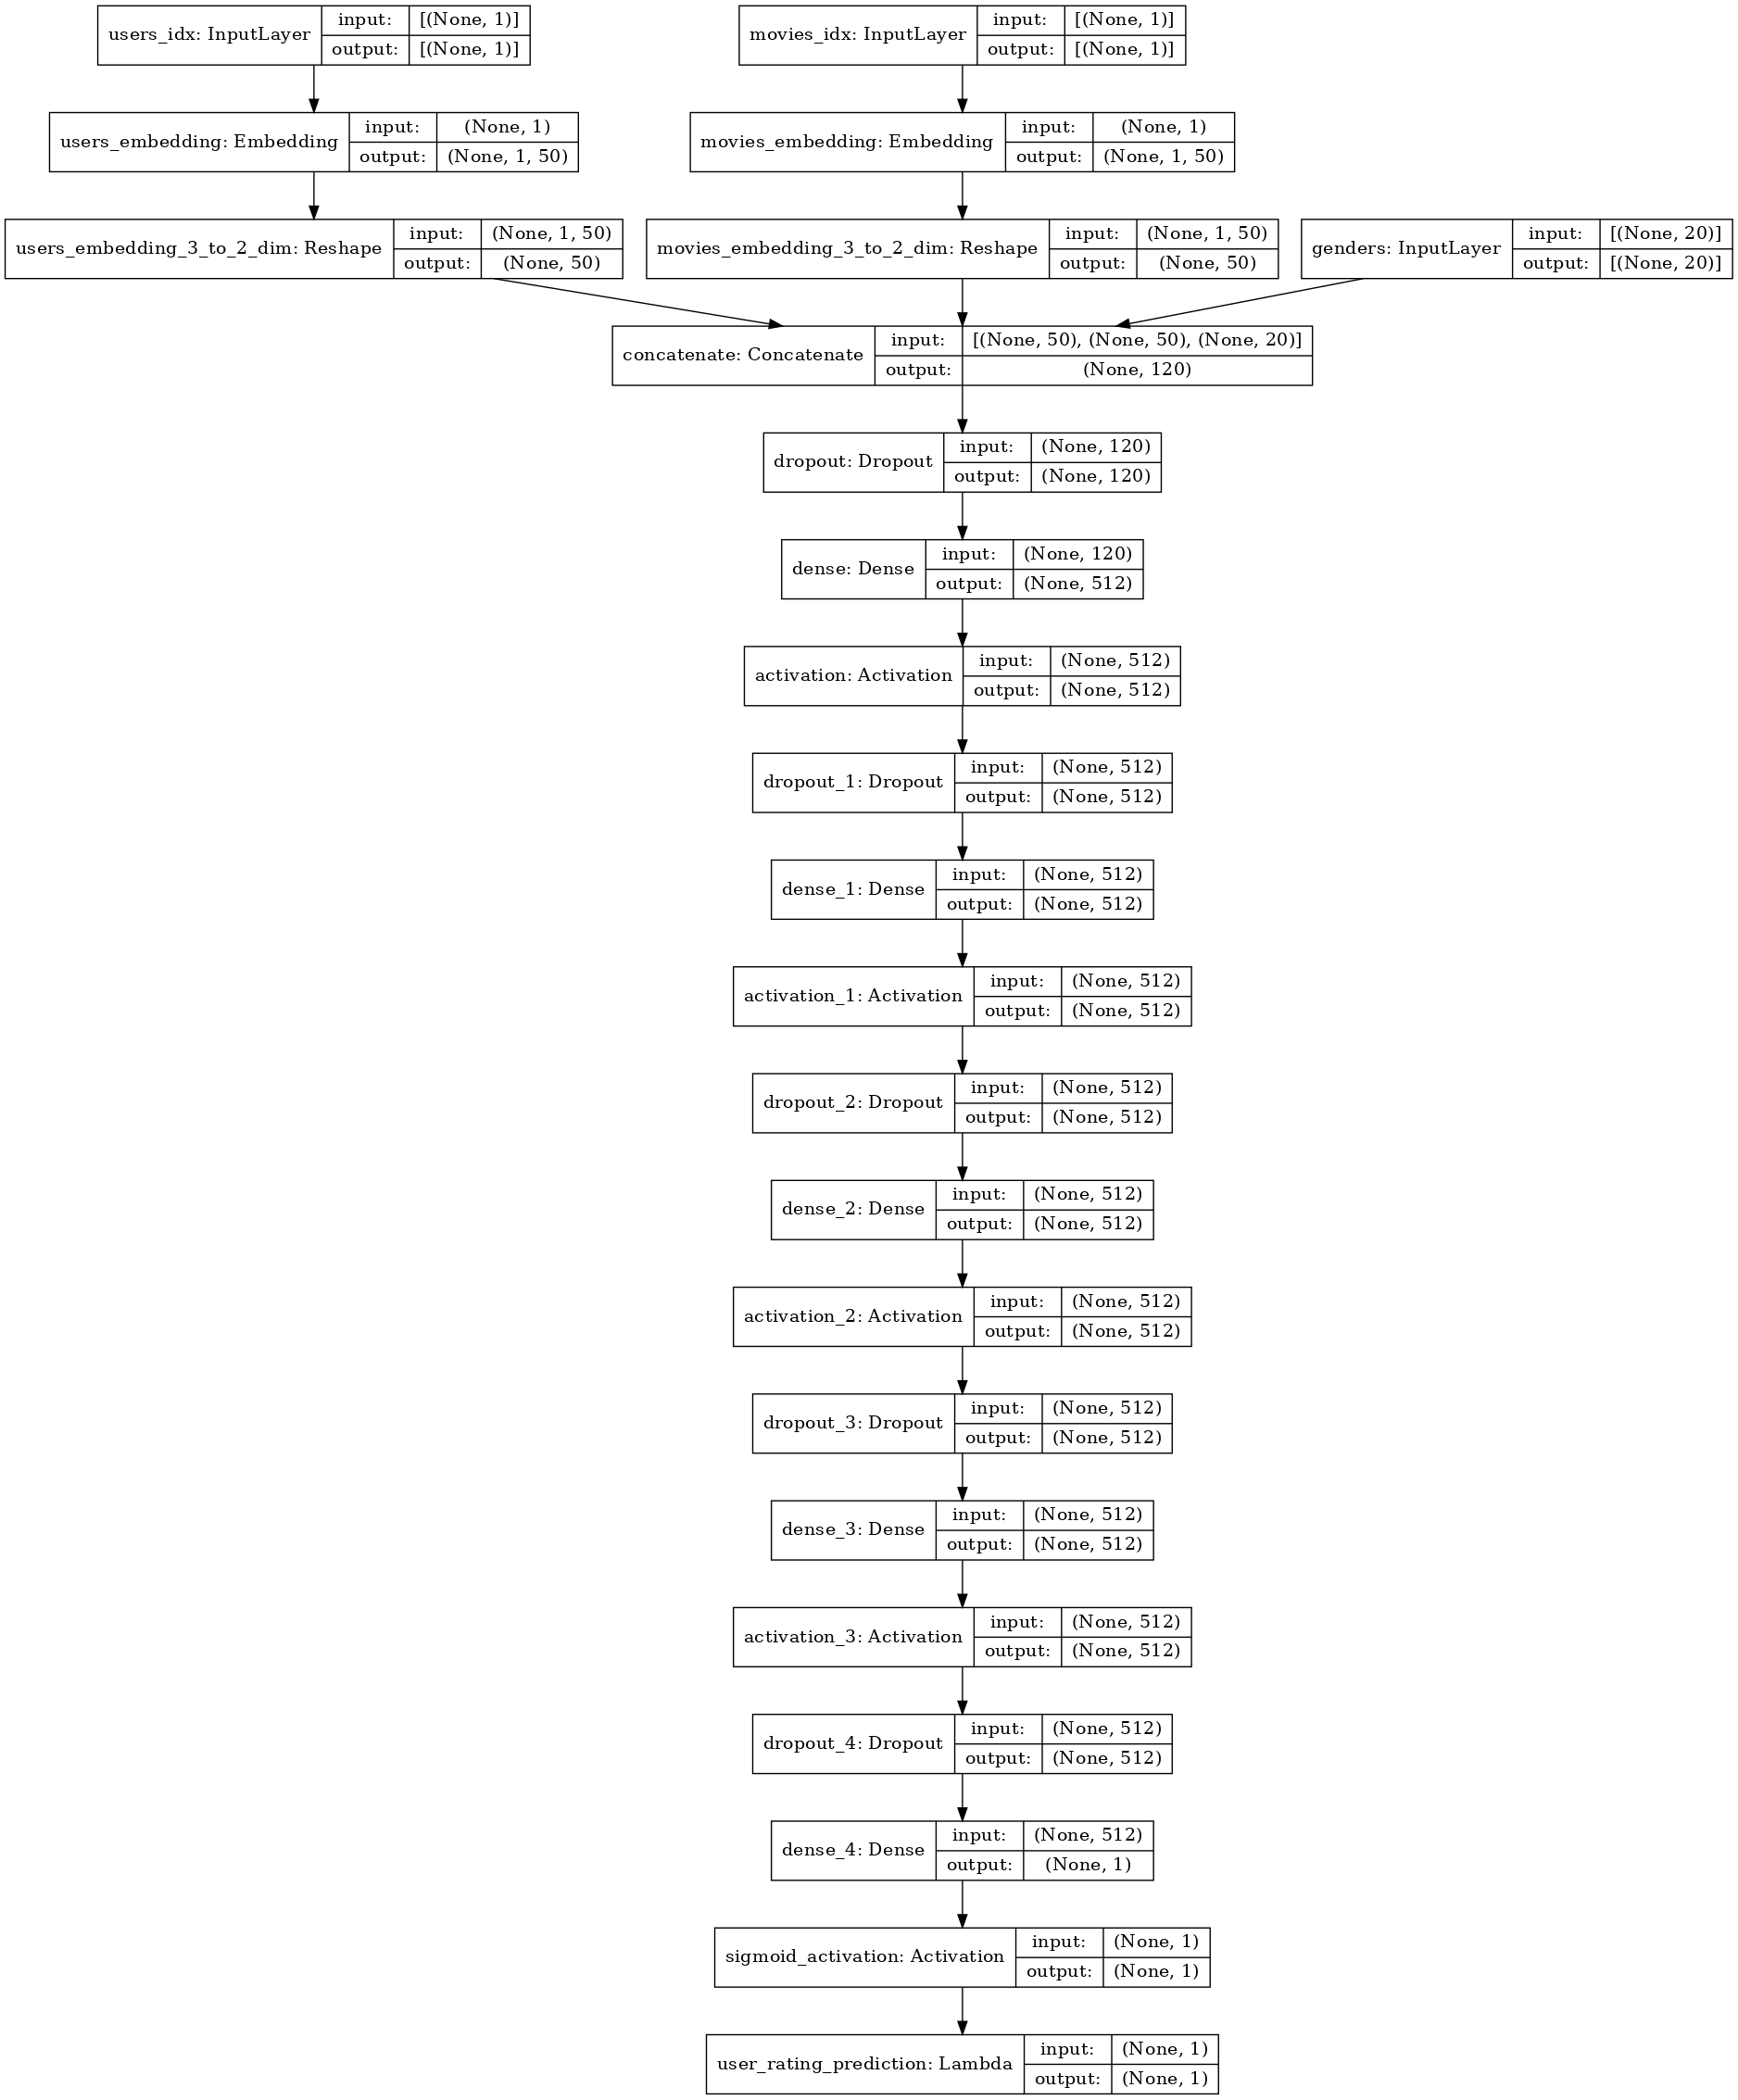

In [27]:
plot_model(model, rankdir="TB")

In [28]:
model.summary()

Model: "Embedding_Feature_Layers_Plus_Dense_Layer_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
users_idx (InputLayer)          [(None, 1)]          0                                            
__________________________________________________________________________________________________
movies_idx (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
users_embedding (Embedding)     (None, 1, 50)        12550       users_idx[0][0]                  
__________________________________________________________________________________________________
movies_embedding (Embedding)    (None, 1, 50)        22450       movies_idx[0][0]                 
____________________________________________________

In [ ]:
if train_model:
    history = model.fit_generator(
        generator=train_generator,
        validation_data=val_generator,
        epochs=epochs,
        verbose=1, 
        callbacks=[
            MetricsPlotter(
                validation_generator=val_generator, 
                metrics_names=['loss'],
                plot_interval=plot_interval,
                evaluate_interval=evaluate_interval,
                batch_size=train_batch_size,
                val_batch_size=val_batch_size
            )
        ]
    )

Check model loss after training process:

In [ ]:
def evaluate_xy_model(model, column_manager, data_frame, batch_size):
    data_generator = RecommendationsDataGenerator(
        data_frame,
        column_manager.features,
        column_manager.labels,
        data_frame.count(),
        shuffle=False
    )
    X, y = data_generator[0]
    return model.evaluate(X, y, batch_size=batch_size, verbose=0)

In [ ]:
val_loss = evaluate_xy_model(model, column_manager, val_set, val_batch_size)
val_loss

Save the weights tthat model has learned:

In [ ]:
## WEIGHTS_PATH = create_path(f'../weights')
WEIGHTS_FILE = f'{WEIGHTS_PATH}/user_movie_genders_deep_model_weights_val_loss_{val_loss}.h5'
model.save_weights(WEIGHTS_FILE)

In [ ]:
session.stop()